# Lightweight PINN: Poisson on the Unit Disk

**PDE:** $\Delta u = x^2 + y^2$ on $\Omega=\{(x,y): x^2+y^2\le 1\}$, with **Dirichlet** $u=0$ on $r=1$.  
**Goal:** Train a **single, light-but-strong** model (good default for this PDE) and evaluate against the analytic solution.

**Analytic solution (for evaluation):**
$u(r) = \tfrac{r^4-1}{16}, \quad u(x,y)=\tfrac{(x^2+y^2)^2-1}{16}.$

### Model Summary — Light Disk PINN

- **Mapping:** $(x, y) \in \mathbb{R}^2 \rightarrow u(x, y) \in \mathbb{R}$
- **Architecture:** 2 → 64 → 64 → 64 → 64 → 1 (tanh activations)
- **Parameters:** ~12.7k total
- **Boundary condition:** Hard Dirichlet  
  $u_\theta(x,y) = (1 - r^2)\,v_\theta(x,y)$  
  ensures $u = 0$ on $r=1$.
- **Activation:** tanh — smooth and differentiable (good for PDE derivatives)
- **Weight init:** Xavier, bias = 0
- **Optimizer:** Adam (lr = 2e−3)
- **Loss:** Mean squared PDE residual  
  $L = \frac{1}{N}\sum (\Delta u_\theta - f(x,y))^2$, where $f(x,y)=x^2+y^2$
- **Sampling:** Uniform in the unit disk  
  $r=\sqrt{U[0,1]}, \; \theta\sim U[0,2\pi)$
- **Batching:** Mini-batches (~2k points) resampled periodically
- **Training:** adam_steps = 6000




## 0. Setup & Utilities

In [105]:
# Core imports: math/time for utilities, numpy for arrays, torch for ML
import math, time, random
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Reproducibility: fix random seeds so results are repeatable across runs
seed = 2025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Choose device (GPU if available) and prefer float32 for speed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
# Set torch default dtype to float32 which speeds up training and reduces memory
torch.set_default_dtype(torch.float32)

# Print chosen device so the user knows whether GPU will be used
print('device:', device)


device: cpu


## 1. Problem definition & analytic solution

In [106]:
# Right-hand side of Poisson: f(x,y) = x^2 + y^2
def f_rhs(x, y):
    """Return pointwise RHS scalar given x and y tensors/arrays."""
    return x**2 + y**2

# Analytic (ground-truth) solution for evaluation: u = ((x^2 + y^2)^2 - 1)/16
def u_true_xy(x, y):
    """Compute analytic solution values using numpy-compatible ops."""
    r2 = x**2 + y**2
    return (r2**2 - 1.0) / 16.0


## 2. Sampling on the unit disk and boundary

- Interior: sample radius via $r=\sqrt{U[0,1]}$, $\theta\sim U[0,2\pi)$.
- Boundary: set $r=1$, uniformly sample $\theta$.


In [107]:
# Sampling utilities for the unit disk
# Interior sampling: sample r ~ sqrt(U[0,1]) and theta ~ U[0,2pi) for uniform area density
def sample_interior(n):
    u = np.random.rand(n)
    r = np.sqrt(u)
    theta = 2*np.pi*np.random.rand(n)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    # Return a torch tensor on the chosen device and dtype
    return torch.tensor(np.stack([x,y], axis=1), dtype=dtype, device=device)

# Boundary sampling: points on r=1 uniformly sampled by theta
def sample_boundary(n):
    theta = 2*np.pi*np.random.rand(n)
    x = np.cos(theta)
    y = np.sin(theta)
    return torch.tensor(np.stack([x,y], axis=1), dtype=dtype, device=device)


## 3. Model (MLP) with Hard Boundary Condition

We enforce $u(x,y)=(1-r^2)\,v_\theta(x,y)$, ensuring $u=0$ when $r=1$.


In [108]:
# Define a simple fully-connected MLP used as the learnable part v_theta of the solution
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=64, depth=4, act=nn.Tanh):
        super().__init__()
        # First layer from input to hidden width, followed by activation
        layers = [nn.Linear(in_dim, width), act()]
        # Hidden layers
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        # Final linear to output dimension
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        # Simple Xavier init for weights and zero biases for stable start
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.net(x)

# Instantiate the base MLP; training will update these parameters
base_model = MLP().to(device=device, dtype=dtype)

# Hard boundary enforcement: we parametrize u = (1 - r^2) * v_theta(x,y).
# This guarantees u=0 on r=1 exactly, so we don't need a BC loss term.
def model_u(xy):
    # xy is a (N,2) tensor where columns are x and y
    x = xy[:,0]; y = xy[:,1]
    r2 = x*x + y*y
    # base_model returns a (N,1) tensor; squeeze to (N,)
    v = base_model(xy).squeeze(-1)
    # Multiply by (1 - r^2) to enforce Dirichlet u=0 on the unit circle
    return (1.0 - r2) * v


In [109]:
# Compute the Laplacian Δu = u_xx + u_yy using PyTorch autograd
def laplacian_autograd(xy, u_fn):
    # Ensure xy requires gradients so autograd can compute derivatives w.r.t. inputs
    xy = xy.requires_grad_(True)
    # u should be a 1D tensor of shape (N,) or (N,1) depending on u_fn
    u = u_fn(xy)
    # First derivatives (u_x, u_y): grads is shape (N,2)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True)[0]
    ux, uy = grads[:,0], grads[:,1]
    # Second derivatives: differentiate ux w.r.t. x to get u_xx, similarly for u_yy
    uxx = torch.autograd.grad(ux, xy, grad_outputs=torch.ones_like(ux),
                              create_graph=True, retain_graph=True)[0][:,0]
    uyy = torch.autograd.grad(uy, xy, grad_outputs=torch.ones_like(uy),
                              create_graph=True, retain_graph=True)[0][:,1]
    return uxx + uyy


## 5. Loss (physics residual only; BC is hard)

In [110]:
# PDE residual loss: MSE of (Δu - f) over interior sample points
def compute_pde_loss(xy_int):
    # Split xy into x and y for evaluating the RHS f
    x_int, y_int = xy_int[:,0], xy_int[:,1]
    # Compute Laplacian of model_u at the interior points
    lap_u = laplacian_autograd(xy_int, model_u)
    # Residual = Δu - f(x,y)
    res = lap_u - f_rhs(x_int, y_int)
    # Return mean squared residual (scalar loss)
    return torch.mean(res**2)


## 6. Training (Adam + mini-batches, fast)

In [111]:
# Fast training loop using Adam and minibatching from a larger interior pool
def train_pinn_fast(
    N_int_total=10000, batch_int=2048,
    adam_steps=3000, adam_lr=2e-3,
    resample_every=200
):
    global base_model
    # Put model into training mode (affects layers like dropout/batchnorm if present)
    base_model.train()
    # Pre-sample a large pool of interior points and draw minibatches from it
    xy_int = sample_interior(N_int_total)
    opt = torch.optim.Adam(base_model.parameters(), lr=adam_lr)
    history = {'pde':[]}

    for step in range(adam_steps):
        # Optionally refresh the pool occasionally to reduce sampling bias
        if step % resample_every == 0 and step > 0:
            xy_int = sample_interior(N_int_total)

        # Random minibatch indices into the pre-sampled pool
        idx_i = torch.randint(0, xy_int.shape[0], (batch_int,), device=device)
        opt.zero_grad()
        # Compute PDE loss on minibatch and backpropagate
        loss_pde = compute_pde_loss(xy_int[idx_i])
        loss_pde.backward()
        opt.step()

        # Simple logging: append the loss every 200 steps to history
        if step % 200 == 0:
            history['pde'].append(float(loss_pde.detach().cpu()))
    return history


## 7. Evaluation & Plots

- RMSE against analytic solution on a 201×201 disk grid
- Residual heatmap and histogram
- A single radial profile (θ = 0) for quick inspection


In [112]:
# Create a Cartesian grid over [-1,1]^2 and return points inside the unit disk
def disk_grid(n=201):
    xs = np.linspace(-1,1,n)
    ys = np.linspace(-1,1,n)
    XX, YY = np.meshgrid(xs, ys, indexing='xy')
    mask = (XX**2 + YY**2) <= 1.0
    # pts is an (M,2) array of coordinates inside the disk
    pts = np.stack([XX[mask], YY[mask]], axis=1)
    return xs, ys, mask, XX, YY, torch.tensor(pts, dtype=dtype, device=device)

# Evaluate model on the disk grid, compute RMSE vs analytic solution and produce plots
def evaluate_model():
    base_model.eval()
    xs, ys, mask, XX, YY, pts = disk_grid(n=201)
    # Predict u at interior grid points (no grad needed)
    with torch.no_grad():
        u_pred = model_u(pts).cpu().numpy()
    # Compute analytic (true) values using numpy arrays
    u_true_vals = u_true_xy(pts[:,0].cpu().numpy(), pts[:,1].cpu().numpy())

    # --- compute metrics ---
    err = u_pred - u_true_vals
    rmse = float(np.sqrt(np.mean(err**2)))
    # Relative RMSE: rmse / RMS(true) for a scale-free error
    u_true_rms = np.sqrt(np.mean(u_true_vals**2))
    rel_rmse = float(rmse / (u_true_rms + 1e-12))

    # Compute PDE residuals (Δu - f) at the same points using autograd; need requires_grad=True
    pts_torch = pts.clone().detach().requires_grad_(True)
    lap = laplacian_autograd(pts_torch, model_u).detach().cpu().numpy()
    rhs = (pts_torch[:,0].detach().cpu().numpy()**2 +
           pts_torch[:,1].detach().cpu().numpy()**2)
    res_vals = lap - rhs

    # Scatter predicted values, absolute error and residuals back onto the full grid for plotting
    full_pred = np.full_like(XX, np.nan, dtype=np.float32)
    full_err  = np.full_like(XX, np.nan, dtype=np.float32)
    full_res  = np.full_like(XX, np.nan, dtype=np.float32)
    idx = np.where(mask.ravel())[0]
    flat_pred = full_pred.ravel(); flat_err = full_err.ravel(); flat_res = full_res.ravel()
    flat_pred[idx] = u_pred
    flat_err[idx]  = np.abs(u_pred - u_true_vals)
    flat_res[idx]  = res_vals
    full_pred = flat_pred.reshape(XX.shape)
    full_err  = flat_err.reshape(XX.shape)
    full_res  = flat_res.reshape(XX.shape)

    print(f"Grid RMSE: {rmse:.3e}   relRMSE: {rel_rmse:.3e}")

    # Plot 1: Prediction field u(x,y)
    plt.figure(figsize=(5,4))
    plt.imshow(full_pred, extent=[xs[0], xs[-1], ys[0], ys[-1]], origin='lower')
    plt.colorbar(); plt.title('Prediction u(x,y)')
    plt.xlabel('x'); plt.ylabel('y'); plt.tight_layout(); plt.show()

    # Plot 2: Absolute pointwise error |u_pred - u_true|
    plt.figure(figsize=(5,4))
    plt.imshow(full_err, extent=[xs[0], xs[-1], ys[0], ys[-1]], origin='lower')
    plt.colorbar(); plt.title('|u_pred - u_true|')
    plt.xlabel('x'); plt.ylabel('y'); plt.tight_layout(); plt.show()

    # Plot 3: Residual field Δu - f
    plt.figure(figsize=(5,4))
    plt.imshow(full_res, extent=[xs[0], xs[-1], ys[0], ys[-1]], origin='lower')
    plt.colorbar(); plt.title('Residual field: Δu - f')
    plt.xlabel('x'); plt.ylabel('y'); plt.tight_layout(); plt.show()

    # Plot 4: Histogram of residuals (to inspect distribution and outliers)
    plt.figure(figsize=(5,4))
    vals = res_vals[np.isfinite(res_vals)]
    plt.hist(vals, bins=50)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual'); plt.ylabel('Count'); plt.tight_layout(); plt.show()

    # Plot 5: Radial profile (theta=0) compare predicted vs analytic
    rs = np.linspace(0,1,200)
    xs_r = rs; ys_r = np.zeros_like(rs)
    xy_r = torch.tensor(np.stack([xs_r, ys_r], axis=1), dtype=dtype, device=device)
    with torch.no_grad():
        up_r = model_u(xy_r).cpu().numpy()
    u_true_r = ((rs**2)**2 - 1.0)/16.0
    plt.figure(figsize=(5,4))
    plt.plot(rs, up_r, label='pred')
    plt.plot(rs, u_true_r, linestyle='--', label='true')
    plt.title('Radial profile at θ=0')
    plt.xlabel('r'); plt.ylabel('u(r)'); plt.legend(); plt.tight_layout(); plt.show()

    return rmse, rel_rmse


## 8. Run

Grid RMSE: 2.448e-04   relRMSE: 5.364e-03


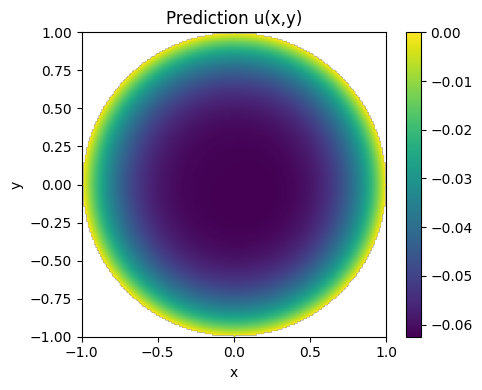

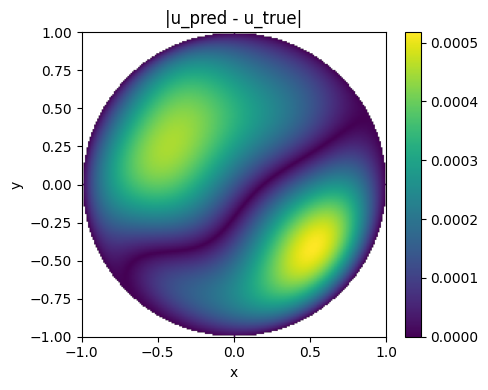

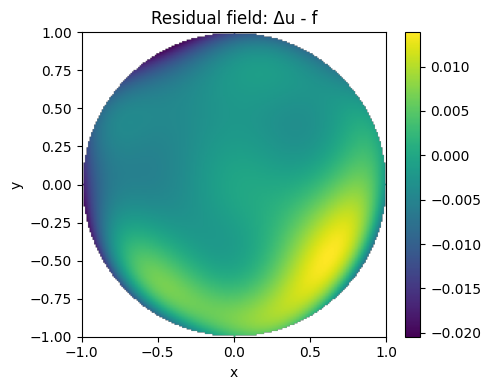

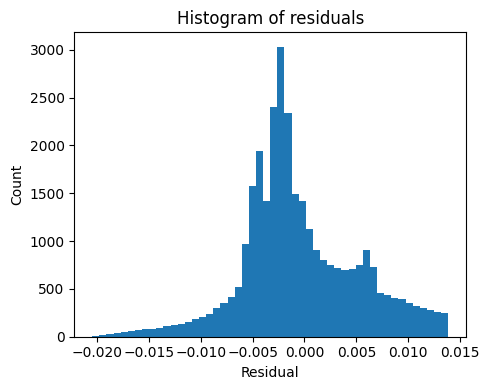

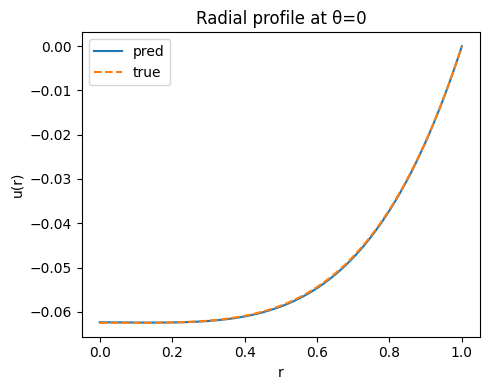

RMSE: 2.448304e-04   relRMSE: 5.363715e-03


In [113]:
history = train_pinn_fast(
    N_int_total=10000,  # total interior pool
    batch_int=2048,     # mini-batch size
    adam_steps=6000,    # short but effective
    adam_lr=2e-3,
    resample_every=200  # refresh sampling every 200 steps
)

#mse = evaluate_model()
#print('RMSE:', rmse)

rmse, rel_rmse = evaluate_model()
print(f"RMSE: {rmse:.6e}   relRMSE: {rel_rmse:.6e}")


### Evaluation Plots 

**Predicted $u(x,y)$:**  
Shows the network’s learned surface; ours is smooth and radially symmetric which matches the expected bowl shape.

**Absolute Error $|u_{\text{pred}} - u_{\text{true}}|$:**  
Shows pointwise error; ours is low (~1e−4) with only faint diagonal bands.

**Residual Field $(\Delta u_\theta - f)$:**  
Shows PDE violation; ours is near zero everywhere with slight diagonal bias.

**Residual Histogram:**  
Shows distribution of PDE errors; ours is tightly centered around zero.

**Radial Profile:**  
Compares predicted vs true $u(r)$ along $\theta=0$; ours overlap neatly.
